# Challenge Avanzado: 

Elaboró: Leon Palomares

Fecha: 24/11/2025

Bases de Datos: Encuesta Nacional sobre Uso de Tiempo, INEGI.


In [41]:
# Imports principales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as spark_sum, when

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PrediccionCalidadVino')\
        .getOrCreate()

In [18]:
df = spark.read.csv('Data/tvar_crea.csv',
                       inferSchema = True,
                       sep=",",
                       header = True)

print(df.show(5))
print(df.printSchema())
print('Numero de columnas: ', len(df.columns))
print('Numero de registros: ', df.count())

+-----------+--------+---------+------------------+------------------+------------------+------------+------------------+--------+-------------------+------------------+------------------+------------------+------------------+--------+------------------+-----------+--------------+-------------------+------------------+--------------------+-----------------------+-----------------------+-------------------+-------------------+--------------------+--------------------+--------------+---------------------+---------------------+---------------------+------------+----------------------+-----------------+------------------+------------------+-------------------+--------------------+--------------+------------------+------------------+----+----+---+---+------+-------+----+-------+-----------+--------+---------+--------+-------+-------+-------+-------+-------+-----+-----+
|   LLAVEMOD|LLAVEVIV| LLAVEHOG| ACTIV_PROD_CON_CP| ACTIV_PROD_SIN_CP|        ACTIV_MERC|TRAB_MERC_PV|         TRAS_TRAB|BU

### Analsis Exploratorio

In [20]:
df_pandas = df.toPandas()

from pyspark.sql import functions as F

# 1. Definir la lista de variables numéricas a analizar
# (Asegúrate de que esta lista contenga los nombres correctos de tus columnas numéricas)
# Ejemplo:
# variables = ['columna_a', 'columna_b', 'columna_c'] 

print("--- Análisis Detallado por Variable (PySpark) ---")

for c in df.columns:
    print(f"\n======================[ {c.upper()} ]======================")
    
    # --- 1. Calcular las estadísticas básicas y cuartiles en una sola operación ---
    stats = df.select(
        # Estadísticas Básicas del código original
        F.mean(c).alias("media"),
        F.expr(f"percentile({c}, array(0.5))")[0].alias("mediana"),
        F.max(c).alias("max_val"), # Renombrado para evitar conflicto con F.max
        F.min(c).alias("min_val"), # Renombrado para evitar conflicto con F.min
        
        # Cuartiles Q1 y Q3
        F.expr(f"percentile({c}, array(0.25))")[0].alias("Q1"),
        F.expr(f"percentile({c}, array(0.75))")[0].alias("Q3")
    ).collect()[0] # Recoge la única fila de resultados

    # --- 2. Extraer valores y calcular límites de outliers ---
    
    Q1 = stats["Q1"]
    Q3 = stats["Q3"]
    RIC = Q3 - Q1
    
    limite_inferior = Q1 - (1.5 * RIC)
    limite_superior = Q3 + (1.5 * RIC)
    
    # --- 3. Mostrar las estadísticas y límites ---
    
    # Estadísticas descriptivas
    print(f"  > Mínimo General: {stats['min_val']:.2f}")
    print(f"  > Máximo General: {stats['max_val']:.2f}")
    print(f"  > Media (Promedio): {stats['media']:.2f}")
    print(f"  > Mediana (Q2): {stats['mediana']:.2f}")

    # Límites de Outliers (Basado en RIC)
    print("\n  > Límites para Detección de Outliers (1.5 * RIC):")
    print(f"    - Q1 (Percentil 25): {Q1:.2f}")
    print(f"    - Q3 (Percentil 75): {Q3:.2f}")
    print(f"    - RIC (Q3 - Q1): {RIC:.2f}")
    print(f"    - Límite INFERIOR: {limite_inferior:.2f}")
    print(f"    - Límite SUPERIOR: {limite_superior:.2f}")
    
    # OPCIONAL: Contar el número de outliers
    outlier_count = df.filter(
        (F.col(c) < limite_inferior) | 
        (F.col(c) > limite_superior)
    ).count()
    print(f"\n  > Total de Outliers detectados: {outlier_count}")
    print("----------------------------------------------------------")

--- Análisis Detallado por Variable (PySpark) ---

======================[ LLAVEMOD ]======================
  > Mínimo General: 10009401101.00
  > Máximo General: 326123120102.00
  > Media (Promedio): 168538315348.07
  > Mediana (Q2): 170109603101.00

  > Límites para Detección de Outliers (1.5 * RIC):
    - Q1 (Percentil 25): 90556902103.00
    - Q3 (Percentil 75): 246130004101.00
    - RIC (Q3 - Q1): 155573101998.00
    - Límite INFERIOR: -142802750894.00
    - Límite SUPERIOR: 479489657098.00

  > Total de Outliers detectados: 0
----------------------------------------------------------

======================[ LLAVEVIV ]======================
  > Mínimo General: 10009401.00
  > Máximo General: 326123120.00
  > Media (Promedio): 168538315.24
  > Mediana (Q2): 170109603.00

  > Límites para Detección de Outliers (1.5 * RIC):
    - Q1 (Percentil 25): 90556902.00
    - Q3 (Percentil 75): 246130004.00
    - RIC (Q3 - Q1): 155573102.00
    - Límite INFERIOR: -142802751.00
    - Límite SU

### Limpieza de datos

In [47]:
print("Número total de columnas:", len(df.columns))

cols_drop = ["LLAVEMOD", "LLAVEVIV", "LLAVEHOG", "CONTROL", "VIV_SEL", "HOGAR", "N_REN", "EST_DIS", "UPM_DIS", "FAC_PER"]
df1 = df.drop(*cols_drop)

cols_con_cp = [c for c in df1.columns if "CON_CP" in c]
df1 = df1.drop(*cols_con_cp)
cols_drop = ["ACTIV_PROD_SIN_CP", "ACTIV_MERC", 
             "PROD_BIEN_HOG_RURAL",
             "PREP_SERV_ALIM_RURAL", "BUS_TRAB"]
df1 = df1.drop(*cols_drop)

print("Número total de columnas restantes:", len(df1.columns))

Número total de columnas: 60
Número total de columnas restantes: 39


In [48]:
# 2. Obtener el conteo original
conteo_original = df1.count()

# Inicializamos el DataFrame a limpiar con el original
df2 = df1

print("--- Aplicando Filtro de Outliers (Rango 95%) ---")

for c in df1.columns:
    print(f"Procesando variable: {c}...")
    
    # a. Calcular el Percentil 2.5 (P025) y el Percentil 97.5 (P975)
    # Estos definen los límites del 95% central de los datos.
    percentiles = df1.select(
        F.expr(f"percentile({c}, array(0.025))")[0].alias("P025"),
        F.expr(f"percentile({c}, array(0.975))")[0].alias("P975")
    ).collect()[0]

    P025 = percentiles["P025"]
    P975 = percentiles["P975"]

    print(f"  Límites [P025, P975]: [{P025:.2f}, {P975:.2f}]")

    # b. Filtrar el DataFrame
    # Mantenemos las filas donde el valor de la columna 'c' esté dentro de los límites
    df2 = df2.filter(
        (F.col(c) >= P025) & (F.col(c) <= P975)
    )
    
    # Nota: El filtrado es acumulativo. Cada paso reduce el número de filas.
    
print("\n------------------------------------------------")

# 3. Mostrar el resumen de la limpieza
conteo_final = df2.count()
eliminados = conteo_original - conteo_final

print(f"Conteo Original de Filas: {conteo_original}")
print(f"Conteo Final de Filas Limpias: {conteo_final}")
print(f"Total de Filas Eliminadas (Outliers): {eliminados}")
print(f"Porcentaje de Datos Eliminados: {(eliminados / conteo_original) * 100:.2f}%")
print("------------------------------------------------")

# Mostrar el esquema del nuevo DataFrame limpio
print("\nEsquema del DataFrame Limpio (df_limpio):")
df2.printSchema()

# Mostrar las primeras filas del DataFrame limpio
print("\nPrimeras 5 Filas del DataFrame Limpio:")
df2.limit(5).show()

--- Aplicando Filtro de Outliers (Rango 95%) ---
Procesando variable: TRAB_MERC_PV...
  Límites [P025, P975]: [0.00, 74.00]
Procesando variable: TRAS_TRAB...
  Límites [P025, P975]: [0.00, 15.00]
Procesando variable: PROD_BIEN_TRAB_AUTO...
  Límites [P025, P975]: [0.00, 14.39]
Procesando variable: TRAB_NO_REM_VOL...
  Límites [P025, P975]: [0.75, 126.00]
Procesando variable: TRAB_NO_REM_HOG...
  Límites [P025, P975]: [0.00, 61.80]
Procesando variable: PREP_SERV_ALIM...
  Límites [P025, P975]: [0.00, 31.50]
Procesando variable: LIMP_VIV...
  Límites [P025, P975]: [0.00, 23.75]
Procesando variable: LIMP_ROP...
  Límites [P025, P975]: [0.00, 10.67]
Procesando variable: MANT_VIV...
  Límites [P025, P975]: [0.00, 3.50]
Procesando variable: COMPRAS_HOG...
  Límites [P025, P975]: [0.00, 6.00]
Procesando variable: PAGOS_TRAM_HOG...
  Límites [P025, P975]: [0.00, 2.00]
Procesando variable: ORG_SUP_HOG...
  Límites [P025, P975]: [0.00, 3.50]
Procesando variable: TRAB_NO_REM_CUID_HOG...
  Límites

In [49]:
df2.summary().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+--------------------+-----------------------+-------------------+--------------------+------------------+---------------------+---------------------+-------------------+----------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|      TRAB_MERC_PV|         TRAS_TRAB|PROD_BIEN_TRAB_AUTO|   TRAB_NO_REM_VOL|   TRAB_NO_REM_HOG|    PREP_SERV_ALIM|          LIMP_VIV|          LIMP_ROP|           MANT_VIV|       COMPRAS_HOG|     PAGOS_TRAM_HOG|  

In [56]:
DF3 = df2[[
    "TRAB_MERC_PV",
    "TRAS_TRAB",
    "PROD_BIEN_TRAB_AUTO",
    "TRAB_NO_REM_VOL",
    "TRAB_NO_REM_HOG",
    "PREP_SERV_ALIM",
    "LIMP_VIV",
    "LIMP_ROP",
    "MANT_VIV",
    "COMPRAS_HOG",
    "PAGOS_TRAM_HOG",
    "ORG_SUP_HOG",
    "TRAB_NO_REM_CUID_HOG",
    "CUID_ESP_INT_HOG_SIN_CP",
    "CUID_INT_0A5_SIN_CP",
    "CUID_INT_6A14_SIN_CP",
    "CUID_INT_15A59",
    "CUID_INT_60MAS_SIN_CP",
    "TRAB_NO_REM_OTROS_HOG",
    "APOY_HOG_FAM",
    "TRAB_DOM_OTROS_HOG_FAM",
    "CUID_ESP_DISC_ENF",
    "CUID_PER_OTROS_HOG",
    "TRAB_NO_REM_NO_FAM"]
]

In [57]:
assembler = VectorAssembler(inputCols=DF3.columns, outputCol="features")
df_vec = assembler.transform(DF3)

corr = Correlation.corr(df_vec, "features", "pearson")
corr_pd = corr.collect()[0]["pearson(features)"].toArray()


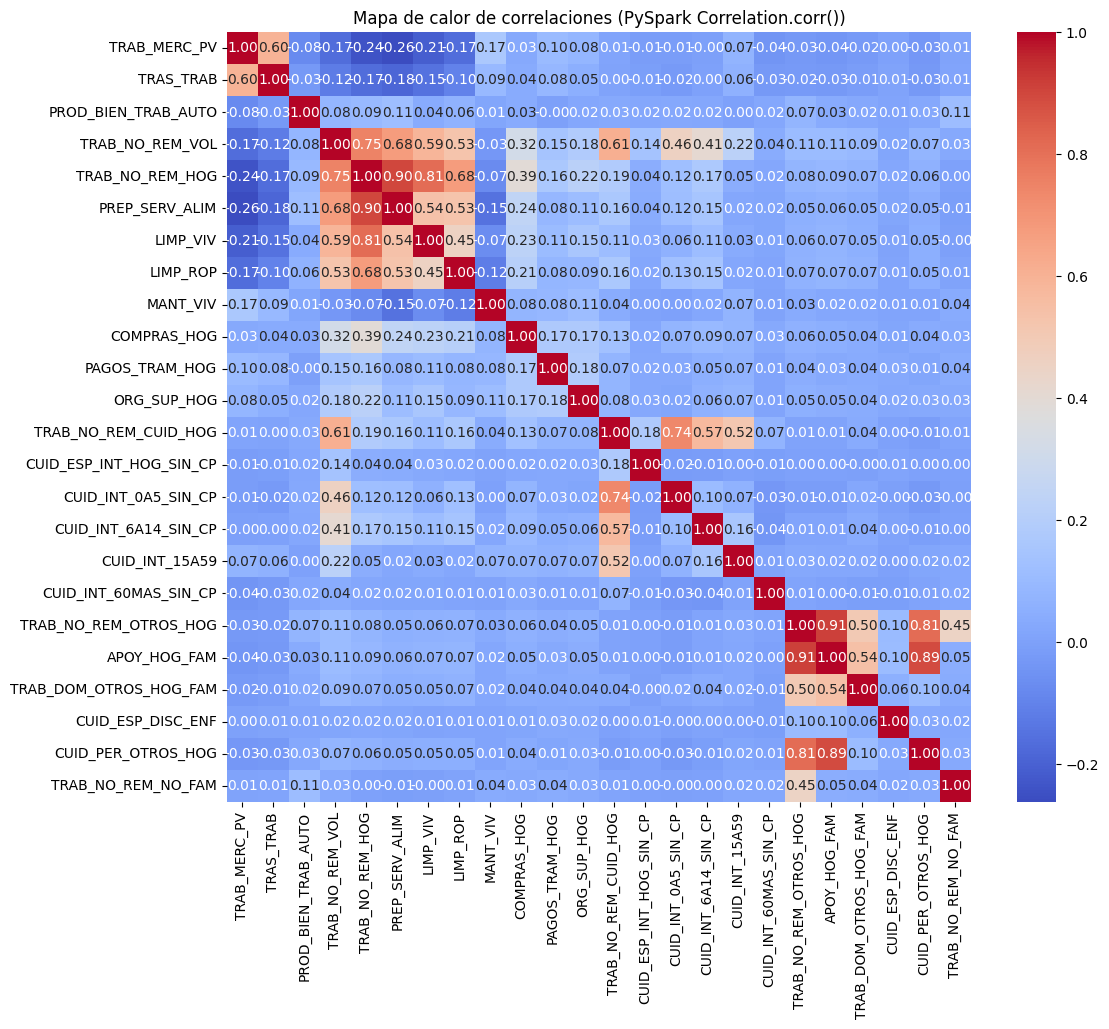

In [ ]:
# Convertir matriz a DataFrame con nombres de variables
corr_df = pd.DataFrame(corr_pd, columns=DF3.columns, index=DF3.columns)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de calor de correlaciones (PySpark Correlation.corr())")
plt.show()


In [62]:
columnas_tiempo = [
    # agrega aquí TODAS tus variables de tiempo
    "TRAB_MERC_PV",
    "TRAS_TRAB",
    "PROD_BIEN_TRAB_AUTO",
    "TRAB_NO_REM_VOL",
    "TRAB_NO_REM_HOG",
    "PREP_SERV_ALIM",
    "LIMP_VIV",
    "LIMP_ROP",
    "MANT_VIV",
    "COMPRAS_HOG",
    "PAGOS_TRAM_HOG",
    "ORG_SUP_HOG",
    "TRAB_NO_REM_CUID_HOG",
    "CUID_INT_0A5_SIN_CP",
    "CUID_INT_6A14_SIN_CP",
    "CUID_INT_15A59",
    "CUID_INT_60MAS_SIN_CP",
    "TRAB_NO_REM_OTROS_HOG",
    "APOY_HOG_FAM",
    "TRAB_DOM_OTROS_HOG_FAM",
    "CUID_ESP_DISC_ENF",
    "CUID_PER_OTROS_HOG",
    "TRAB_NO_REM_NO_FAM",
    "ACTIV_CUID_PER",
    "ACTIV_ESTUD",
    "ACTIV_CONVIV"
]

df2 = df2.withColumn(
    "TOTAL_TIEMPO",
    sum([F.col(c) for c in columnas_tiempo])
)


In [68]:
sobrecarga = [
    "TRAB_MERC_PV",
    "TRAS_TRAB",
    "PROD_BIEN_TRAB_AUTO",
    "TRAB_NO_REM_VOL",
    "TRAB_NO_REM_HOG",
    "PREP_SERV_ALIM",
    "LIMP_VIV",
    "LIMP_ROP",
    "MANT_VIV",
    "COMPRAS_HOG",
    "PAGOS_TRAM_HOG",
    "ORG_SUP_HOG",
    "TRAB_NO_REM_CUID_HOG",
    "CUID_ESP_INT_HOG_SIN_CP",
    "CUID_INT_0A5_SIN_CP",
    "CUID_INT_6A14_SIN_CP",
    "CUID_INT_15A59",
    "CUID_INT_60MAS_SIN_CP",
    "TRAB_NO_REM_OTROS_HOG",
    "APOY_HOG_FAM",
    "TRAB_DOM_OTROS_HOG_FAM",
    "CUID_ESP_DISC_ENF",
    "CUID_PER_OTROS_HOG",
    "TRAB_NO_REM_NO_FAM"
]

sobrecarga = [v for v in sobrecarga if v in df2.columns]

df2 = df2.withColumn(
    "SOBRECARGA",
    sum([col(v) for v in sobrecarga])
)

In [69]:
# Obtener media para binarizar
media_sobrecarga = df2.selectExpr("avg(SOBRECARGA) as mean").collect()[0]["mean"]

# Crear variable binaria
df2 = df2.withColumn(
    "SOBRECARGA_ALTA",
    when(col("SOBRECARGA") > media_sobrecarga, 1).otherwise(0)
)

df2.select("SOBRECARGA", "SOBRECARGA_ALTA").show(20)

+------------------+---------------+
|        SOBRECARGA|SOBRECARGA_ALTA|
+------------------+---------------+
| 77.49999999999999|              0|
|44.333333333333336|              0|
|             52.25|              0|
|             35.75|              0|
|               6.5|              0|
|              94.0|              0|
|123.34999999999998|              1|
| 81.25000000000001|              0|
|39.449999999999996|              0|
|142.74999999999994|              1|
|            198.95|              1|
|            140.75|              1|
| 82.36666666666667|              0|
| 93.41666666666666|              0|
|            124.75|              1|
| 83.41666666666666|              0|
|243.58333333333331|              1|
|125.49999999999999|              1|
|             193.5|              1|
|              35.5|              0|
+------------------+---------------+
only showing top 20 rows



In [78]:
df2 = df2.withColumn(
    "SOBRECARGA_ALTA",
    F.when(F.col("TOTAL_TIEMPO") > p75, 1).otherwise(0)
)


<Axes: title={'center': 'TOTAL_TIEMPO'}, xlabel='SEXO'>

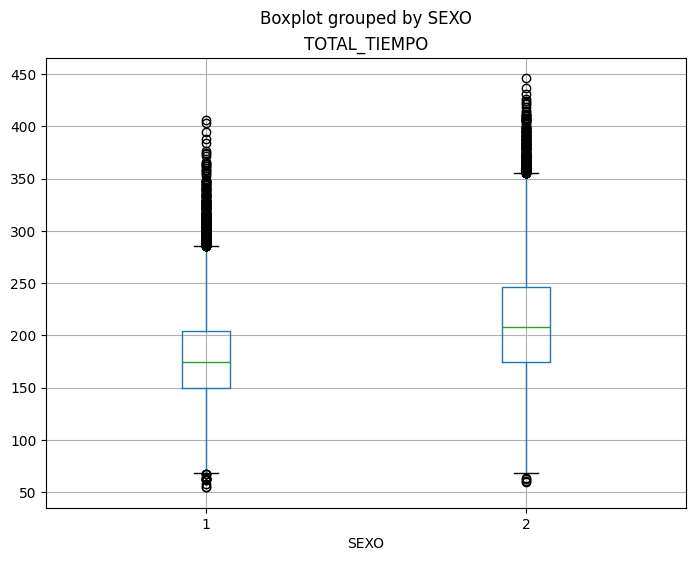

In [84]:
col_pd = df2.toPandas()

col_pd.boxplot(column="TOTAL_TIEMPO", by="SEXO", figsize=(8,6))

In [90]:
feature_columns = [
    "EDAD", "SEXO", "CVEGEO", "NIV", "COND_AEE"
]

In [92]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_unscaled")
df_model = assembler.transform(df2)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")
df_scaled = scaler.fit(df_model).transform(df_model)


In [96]:
train, test = df_scaled.randomSplit([0.82, 0.18], seed=42)

In [97]:
RL = LogisticRegression(
    featuresCol="features",
    labelCol="SOBRECARGA_ALTA",
    maxIter=50
)

ModeloRL = RL.fit(train)

In [101]:
weights = ModeloRL.coefficients.toArray()
importance = pd.DataFrame({"variable": feature_columns, "coef": weights})
importance.sort_values("coef", ascending=False)


,variable,coef
1,SEXO,0.792474
3,NIV,0.200129
2,CVEGEO,0.051115
0,EDAD,-0.107881
4,COND_AEE,-0.270100


In [102]:
predictions = ModeloRL.transform(test)

Evaluador = BinaryClassificationEvaluator(labelCol="SOBRECARGA_ALTA", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
DF_RL = Evaluador.evaluate(predictions)
print(f"Área bajo la curva ROC: {DF_RL:.4f}")

Área bajo la curva ROC: 0.7160


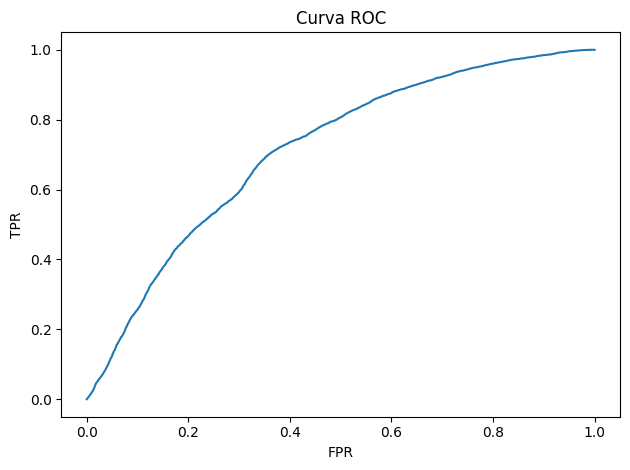

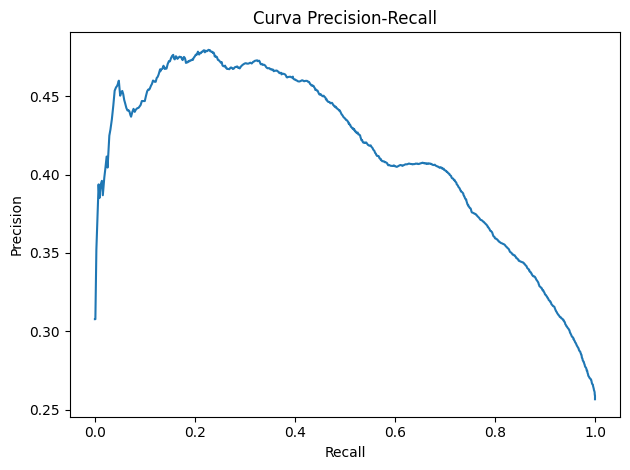

In [103]:
train_summary = ModeloRL.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.tight_layout()
plt.show()

In [104]:
spark.stop()